# Evasion

> Attacks against classification models that construct special inputs (a.k.a adversarial examples) that appear natural to a human but are misclassified by the model.

In [1]:
#| default_exp evasion

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
from advertorch.attacks import LinfPGDAttack
from dataclasses import dataclass
from typing import Callable

import torch
from fastai.vision.all import *

from torch.nn import Module, Sequential
from torch.nn.parameter import Parameter


class LinfProjectionCallback(Callback):
    def __init__(self, epsilon, x, rand_init):
        super().__init__()
        self.epsilon = epsilon
        self.p = Parameter(torch.rand(x.shape) * self.epsilon if rand_init else torch.zeros(x.shape))
        self.clamp_pixel_values(x)

    def before_step(self):
        with torch.no_grad():
            self.p.grad.sign_()

    def after_batch(self):
        with torch.no_grad():
            self.p.clamp_(-self.epsilon, self.epsilon)  # keep perturbation small
            self.clamp_pixel_values(self.x)

    def clamp_pixel_values(self, x):
        with torch.no_grad():
            x = x.to(self.p.device)
            self.p.data = (x + self.p).clamp(0., 1.) - x


@dataclass
class PGD(object):
    model: Module
    loss: Callable
    min_delta: float = 1e-2
    min_lr: float = 1e-6
    lr: float = None
    # defaults taken from advertorch
    epsilon: float = 0.3
    epoch_size: int = 10
    n_epochs: int = 4
    rand_init: bool = True

    def __post_init__(self):
        if self.lr is None:
            self.lr = self.epsilon / self.epoch_size

    def perturb_dl(self, dl: DataLoader):
        return torch.cat([self.perturb_batch(x, y) for x, y in dl])

    def perturb(self, x, y):
        x, y = x.detach().clone(), y.detach().clone()  # TODO: can I get rid of this?
        self.model.eval()
        self.model.requires_grad_(False)

        proj_callback = LinfProjectionCallback(self.epsilon, x, self.rand_init)
        pert_module = Lambda(proj_callback.p.add)
        pert_module.p = proj_callback.p  # to register as a parameter

        class TrainLoop(TrainEvalCallback):
            def before_train(self):
                super().before_train()
                self.model.eval()

            def before_validate(self):
                raise CancelValidException

        learner = Learner(Datasets(range(self.epoch_size), [lambda _: x, lambda _: y]).dataloaders(bs=None, drop_last=False, shuffle=False),
                          Sequential(pert_module, self.model),
                          CrossEntropyLossFlat(),
                          SGD,
                          self.lr,
                          train_bn=False,
                          default_cbs=False,
                          cbs=[TrainLoop, Recorder(valid_metrics=False), ProgressCallback, BnFreeze,
                               proj_callback,
                               ReduceLROnPlateau('train_loss', min_delta=self.min_delta, min_lr=self.min_lr),
                               EarlyStoppingCallback('train_loss', min_delta=self.min_delta / 10)
                               ])
        learner.fit(self.n_epochs)
        p = proj_callback.p.data.detach().cpu()
        return x.cpu() + p

In [4]:
from fastai_datasets.all import *
from similarity_learning.all import *

In [5]:
mnist = MNIST()
classifier = MLP(10)
learner = Learner(mnist.dls(), classifier, metrics=accuracy)
learner.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.151897,0.138076,0.963900,00:21


In [6]:
x, y = mnist.valid.random_sub_dsets(10).load(device='cpu')

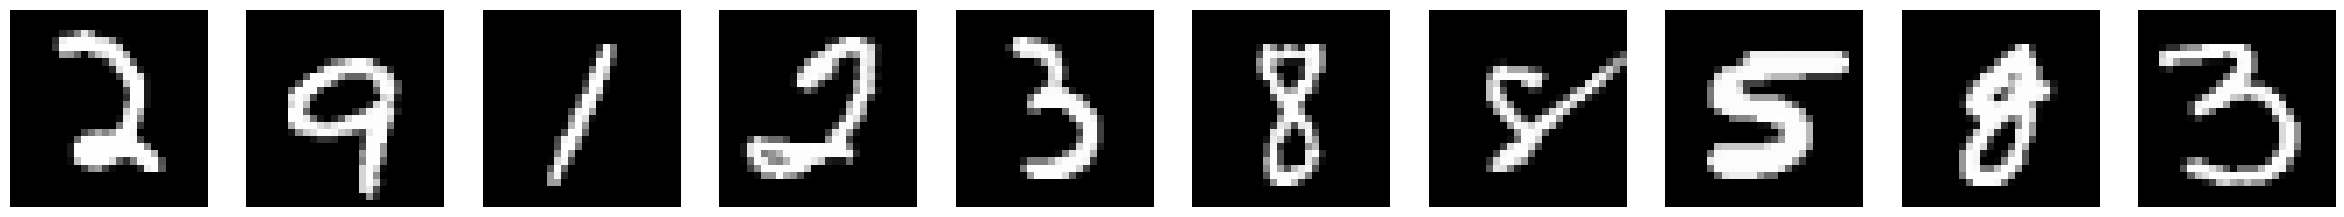

In [7]:
show_images(x)
benign_accuracy = accuracy(classifier(x.cuda()), y.cuda())
test(benign_accuracy, .9, ge)

In [8]:
attack = PGD(classifier, CrossEntropyLossFlat())
y_hat = (y + 1) % 10
x_hat = attack.perturb(x, y_hat)

epoch,train_loss,time
0,2.092967,00:00
1,1.144459,00:00
2,0.732408,00:00
3,0.517715,00:00


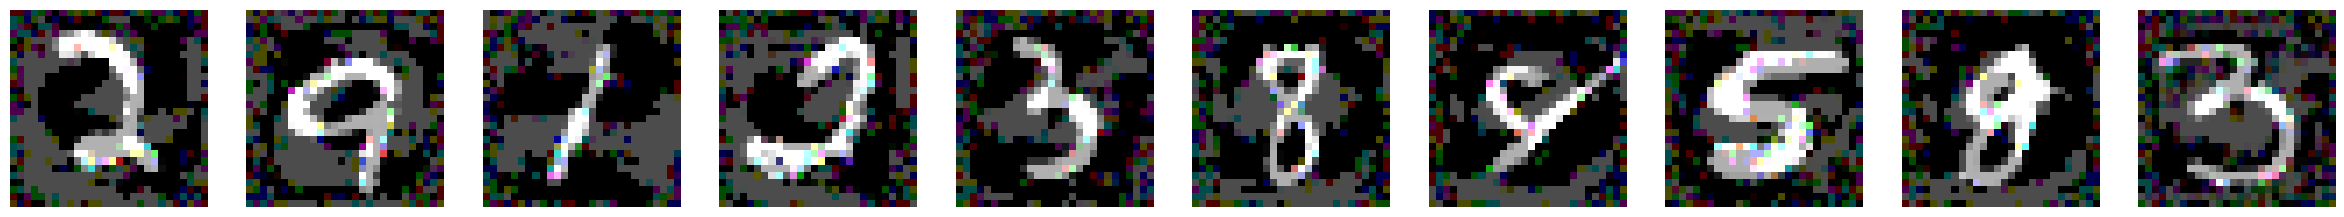

In [9]:
show_images(x_hat.cpu())
attack_success_rate = accuracy(classifier(x_hat.cuda()), y_hat.cuda())
test(attack_success_rate, .9, ge)

In [10]:
#| hide
import nbdev; nbdev.nbdev_export()